# 33.3.6 Mini-Project - Churn Prediction AWS

## Platform/package configurations

In [ ]:
!conda update -y -n base -c conda-forge conda

In [ ]:
!conda install -c conda-forge shap --yes
!pip install smdebug --upgrade
!pip install s3fs shap boto3 pandas numpy matplotlib sagemaker smdebug

In [ ]:
!pip install s3fs --upgrade

In [9]:
import re
import s3fs
import shap
import time
import boto3
import pandas as pd
import numpy as np

from itertools import islice
import matplotlib.pyplot as plt

import sagemaker
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.session import Session
from sagemaker.inputs import TrainingInput
from sagemaker.debugger import DebuggerHookConfig,CollectionConfig
from sagemaker.debugger import rule_configs, Rule
from smdebug.trials import create_trial
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner
)

### Configuration Variables

In [4]:
## Setup some configuration variables
model_name = "end-to-end_churn_model"
bucket = "mini-project-churn-prediction"
datadir = "data"
datafile = "storedata_total.xlsx"


In [10]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
region = sagemaker_session.boto_region_name

## Data Loading/Pre-processing

In [11]:
def preprocess_data(file_path):
    df = pd.read_excel(file_path)
    ## Convert to datetime columns
    df["firstorder"]=pd.to_datetime(df["firstorder"],errors='coerce')
    df["lastorder"] = pd.to_datetime(df["lastorder"],errors='coerce')
    ## Drop Rows with null values
    df = df.dropna()
    ## Create Column which gives the days between the last order and the first order
    df["first_last_days_diff"] = (df['lastorder']-df['firstorder']).dt.days
    ## Create Column which gives the days between when the customer record was created and the first order
    df['created'] = pd.to_datetime(df['created'])
    df['created_first_days_diff']=(df['created']-df['firstorder']).dt.days
    ## Drop Columns
    df.drop(['custid','created','firstorder','lastorder'],axis=1,inplace=True)
    ## Apply one hot encoding on favday and city columns
    df = pd.get_dummies(df,prefix=['favday','city'],columns=['favday','city'])
    return df

In [12]:
## Pull the data file from our S3 bucket and pre-process
bucket_path = f"s3://{bucket}/{datadir}/{datafile}"
print(bucket_path)
storedata = preprocess_data(bucket_path)

s3://mini-project-churn-prediction/data/storedata_total.xlsx


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [13]:
storedata.head(15)

,retained,esent,eopenrate,eclickrate,avgorder,ordfreq,paperless,refill,doorstep,first_last_days_diff,...,favday_Monday,favday_Saturday,favday_Sunday,favday_Thursday,favday_Tuesday,favday_Wednesday,city_BLR,city_BOM,city_DEL,city_MAA
0,0,29,100.000000,3.448276,14.52,0.000000,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,1,95,92.631579,10.526316,83.69,0.181641,1,1,1,1024,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0.000000,0.000000,33.58,0.059908,0,0,0,217,...,0,0,0,0,0,1,0,0,1,0
3,0,0,0.000000,0.000000,54.96,0.000000,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
4,1,30,90.000000,13.333333,111.91,0.008850,0,0,0,791,...,1,0,0,0,0,0,0,1,0,0
5,1,46,80.434783,15.217391,175.10,0.141176,1,1,0,1190,...,0,0,0,0,0,1,0,0,1,0
6,1,60,43.333333,6.666667,116.55,0.125000,0,1,0,976,...,0,0,0,0,0,0,0,1,0,0
7,1,64,28.125000,15.625000,68.10,0.040094,1,1,0,848,...,0,0,0,0,0,0,0,0,1,0
8,1,45,0.000000,0.000000,46.60,0.000000,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
9,1,34,94.117647,8.823529,66.07,0.133789,1,0,0,1024,...,1,0,0,0,0,0,0,0,1,0


## Split Train, Test and Validation Datasets

In [15]:
def split_datasets(df):
    y = df.pop("retained")
    X_pre = df
    y_pre = y.to_numpy().reshape(len(y), 1)
    feature_names = list(X_pre.columns)
    X = np.concatenate((y_pre, X_pre), axis=1)
    np.random.shuffle(X)
    train,validation,test = np.split(X, [int(.7*len(X)), int(.85*len(X))])
    return feature_names, train, validation, test

In [16]:
feature_names, train, validation, test = split_datasets(storedata)

In [17]:
## Save the split datasets to S3 bucket
pd.DataFrame(train).to_csv(f"s3://{bucket}/data/train/train.csv", header=False, index=False)
pd.DataFrame(validation).to_csv(f"s3://{bucket}/data/validation/validation.csv", header=False, index=False)
pd.DataFrame(test).to_csv(f"s3://{bucket}/data/test/test.csv", header=False, index=False)

### 5. Hyperparameter Tuning HPO

In [18]:
s3_input_train = TrainingInput(
    s3_data=f"s3://{bucket}/data/train/", content_type="csv")
s3_input_validation = TrainingInput(
    s3_data=f"s3://{bucket}/data/validation/", content_type="csv")

In [19]:
fixed_hyperparameters = {
    "eval_metric":"auc",
    "objective":"binary:logistic",
    "num_round":"100",
    "rate_drop":"0.3",
    "tweedie_variance_power":"1.4"
}

In [20]:
# Prepare estimator model using SageMaker's built-in xgboost algorithm
sess = sagemaker.Session()
container = sagemaker.image_uris.retrieve("xgboost", region, "0.90-2")

estimator = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=5,
    hyperparameters=fixed_hyperparameters,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/output".format(bucket),
    sagemaker_session=sagemaker_session
)

In [21]:
# Hyperparameter ranges for tuning
hyperparameter_ranges = {
    "eta": ContinuousParameter(0, 1),
    "min_child_weight": ContinuousParameter(1, 10),
    "alpha": ContinuousParameter(0, 2),
    "max_depth": IntegerParameter(1, 10),
}

In [22]:
# Set tuning metric
objective_metric_name = "validation:auc"

In [23]:
tuner = HyperparameterTuner(
    estimator, objective_metric_name, hyperparameter_ranges, max_jobs=20, max_parallel_jobs=4)

In [24]:
tuner.fit({
    "train" : s3_input_train,
    "validation" : s3_input_validation
    }, include_cls_metadata=False)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.........................................................................................................!


In [25]:
tuning_job_result = boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name
)

job_count = tuning_job_result["TrainingJobStatusCounters"]["Completed"]
print("%d training jobs have completed" %job_count)

20 training jobs have completed


In [26]:
from pprint import pprint

if tuning_job_result.get("BestTrainingJob", None):
    print("Best Model found so far:")
    pprint(tuning_job_result["BestTrainingJob"])
else:
    print("No training jobs have reported results yet.")

Best Model found so far:
{'CreationTime': datetime.datetime(2024, 10, 19, 19, 55, 14, tzinfo=tzlocal()),
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:auc',
                                                 'Value': 0.9827899932861328},
 'ObjectiveStatus': 'Succeeded',
 'TrainingEndTime': datetime.datetime(2024, 10, 19, 19, 56, 23, tzinfo=tzlocal()),
 'TrainingJobArn': 'arn:aws:sagemaker:us-west-2:605134454307:training-job/sagemaker-xgboost-241019-1947-017-0337e7a7',
 'TrainingJobName': 'sagemaker-xgboost-241019-1947-017-0337e7a7',
 'TrainingJobStatus': 'Completed',
 'TrainingStartTime': datetime.datetime(2024, 10, 19, 19, 55, 18, tzinfo=tzlocal()),
 'TunedHyperParameters': {'alpha': '1.8079533513690833',
                          'eta': '0.11712281295206728',
                          'max_depth': '4',
                          'min_child_weight': '5.429219859930072'}}


In [27]:
best_hyperparameters = tuning_job_result["BestTrainingJob"]["TunedHyperParameters"]

In [28]:
best_hyperparameters

{'alpha': '1.8079533513690833',
 'eta': '0.11712281295206728',
 'max_depth': '4',
 'min_child_weight': '5.429219859930072'}

### 7. XGBoost Model with SageMaker Debugger

In [29]:
hyperparameters = {**fixed_hyperparameters,**best_hyperparameters}
save_interval = 5
base_job_name = "demo-smdebug-xgboost-churn-classification"

In [30]:
container = sagemaker.image_uris.retrieve("xgboost", region, "0.90-2")

In [31]:
estimator = sagemaker.estimator.Estimator(
    container,
    role,
    base_job_name=base_job_name,
    instance_count=5,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/output".format(bucket),
    sagemaker_session=sess,
    hyperparameters=hyperparameters,
    max_run=1800,
    debugger_hook_config = DebuggerHookConfig(
        s3_output_path=f"s3://{bucket}/debugger/",  # Required
        collection_configs=[
            CollectionConfig(
                name="metrics",
                parameters={
                    "save_interval": "5"
                }),
            CollectionConfig(
                name="feature_importance", parameters={"save_interval": "5"}
            ),
            CollectionConfig(name="full_shap", parameters={"save_interval": "5"}),
            CollectionConfig(name="average_shap", parameters={"save_interval": "5"}),
        ]
    ),
    rules=[
        Rule.sagemaker(
            rule_configs.loss_not_decreasing(),
            rule_parameters={
                "collection_names": "metrics",
                "num_steps": "10",
            },
        ),
    ]
)

In [32]:
estimator.fit(
        {"train":s3_input_train,"validation":s3_input_validation},wait=False
    )

INFO:sagemaker:Creating training-job with name: demo-smdebug-xgboost-churn-classificati-2024-10-19-20-21-37-363


In [33]:
%%time

for _ in range(36):
    job_name = estimator.latest_training_job.name
    client = estimator.sagemaker_session.sagemaker_client
    description = client.describe_training_job(TrainingJobName=job_name)
    training_job_status = description["TrainingJobStatus"]
    rule_job_summary = estimator.latest_training_job.rule_job_summary()
    rule_evaluation_status = rule_job_summary[0]["RuleEvaluationStatus"]
    print(
        "Training job status: {}, Rule Evaluation Status: {}".format(
            training_job_status, rule_evaluation_status
        )
    )
    if training_job_status in ["Completed", "Failed"]:
        break
    time.sleep(10)

Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation

### 8. Analyze Debugger Output

In [34]:
estimator.latest_training_job.rule_job_summary()

[{'RuleConfigurationName': 'LossNotDecreasing',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-west-2:605134454307:processing-job/demo-smdebug-xgboost-churn-LossNotDecreasing-fb8727c5',
  'RuleEvaluationStatus': 'InProgress',
  'LastModifiedTime': datetime.datetime(2024, 10, 19, 20, 25, 23, 4000, tzinfo=tzlocal())}]

In [35]:
s3_output_path = estimator.latest_job_debugger_artifacts_path()
trial = create_trial(s3_output_path)

[2024-10-19 20:25:36.412 ip-172-16-91-225.us-west-2.compute.internal:4356 INFO s3_trial.py:42] Loading trial debug-output at path s3://mini-project-churn-prediction/debugger/demo-smdebug-xgboost-churn-classificati-2024-10-19-20-21-37-363/debug-output


In [36]:
trial.tensor_names()

[2024-10-19 20:25:37.788 ip-172-16-91-225.us-west-2.compute.internal:4356 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2024-10-19 20:25:38.809 ip-172-16-91-225.us-west-2.compute.internal:4356 INFO trial.py:210] Loaded all steps


['average_shap/f0',
 'average_shap/f1',
 'average_shap/f10',
 'average_shap/f11',
 'average_shap/f12',
 'average_shap/f13',
 'average_shap/f14',
 'average_shap/f15',
 'average_shap/f16',
 'average_shap/f17',
 'average_shap/f18',
 'average_shap/f19',
 'average_shap/f2',
 'average_shap/f20',
 'average_shap/f3',
 'average_shap/f4',
 'average_shap/f5',
 'average_shap/f6',
 'average_shap/f7',
 'average_shap/f8',
 'average_shap/f9',
 'feature_importance/cover/f0',
 'feature_importance/cover/f1',
 'feature_importance/cover/f10',
 'feature_importance/cover/f11',
 'feature_importance/cover/f12',
 'feature_importance/cover/f13',
 'feature_importance/cover/f14',
 'feature_importance/cover/f15',
 'feature_importance/cover/f16',
 'feature_importance/cover/f17',
 'feature_importance/cover/f18',
 'feature_importance/cover/f19',
 'feature_importance/cover/f2',
 'feature_importance/cover/f20',
 'feature_importance/cover/f3',
 'feature_importance/cover/f4',
 'feature_importance/cover/f5',
 'feature_impo

In [37]:
trial.tensor("average_shap/f1").values()

{0: array([2.689452e-05], dtype=float32),
 5: array([0.00023925], dtype=float32),
 10: array([0.00618168], dtype=float32),
 15: array([0.01385565], dtype=float32),
 20: array([0.0102916], dtype=float32),
 25: array([0.01017182], dtype=float32),
 30: array([0.00746096], dtype=float32),
 35: array([0.00277561], dtype=float32),
 40: array([0.0214961], dtype=float32),
 45: array([0.04213126], dtype=float32),
 50: array([0.05044094], dtype=float32),
 55: array([0.05216758], dtype=float32),
 60: array([0.05103824], dtype=float32),
 65: array([0.05617724], dtype=float32),
 70: array([0.06776749], dtype=float32),
 75: array([0.07261574], dtype=float32),
 80: array([0.07741008], dtype=float32),
 85: array([0.0806835], dtype=float32),
 90: array([0.08971601], dtype=float32),
 95: array([0.08580282], dtype=float32)}

In [38]:
MAX_PLOTS = 35


def get_data(trial, tname):
    """
    For the given tensor name, walks though all the iterations
    for which you have data and fetches the values.
    Returns the set of steps and the values.
    """
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals


def match_tensor_name_with_feature_name(tensor_name, feature_names=feature_names):
    feature_tag = tensor_name.split("/")
    for ifeat, feature_name in enumerate(feature_names):
        if feature_tag[-1] == "f{}".format(str(ifeat)):
            return feature_name
    return tensor_name


def plot_collection(trial, collection_name, regex=".*", figsize=(8, 6)):
    """
    Takes a `trial` and a collection name, and
    plots all tensors that match the given regex.
    """
    fig, ax = plt.subplots(figsize=figsize)
    tensors = trial.collection(collection_name).tensor_names
    matched_tensors = [t for t in tensors if re.match(regex, t)]
    for tensor_name in islice(matched_tensors, MAX_PLOTS):
        steps, data = get_data(trial, tensor_name)
        ax.plot(steps, data, label=match_tensor_name_with_feature_name(tensor_name))

    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_xlabel("Iteration")

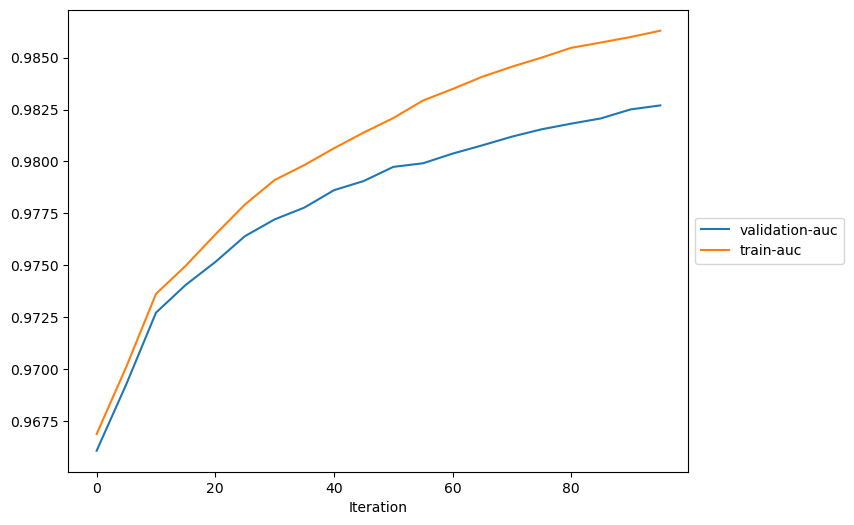

In [39]:
plot_collection(trial, "metrics")

In [40]:
def plot_feature_importance(trial, importance_type="weight"):
    SUPPORTED_IMPORTANCE_TYPES = ["weight", "gain", "cover", "total_gain", "total_cover"]
    if importance_type not in SUPPORTED_IMPORTANCE_TYPES:
        raise ValueError(f"{importance_type} is not one of the supported importance types.")
    plot_collection(trial, "feature_importance", regex=f"feature_importance/{importance_type}/.*")

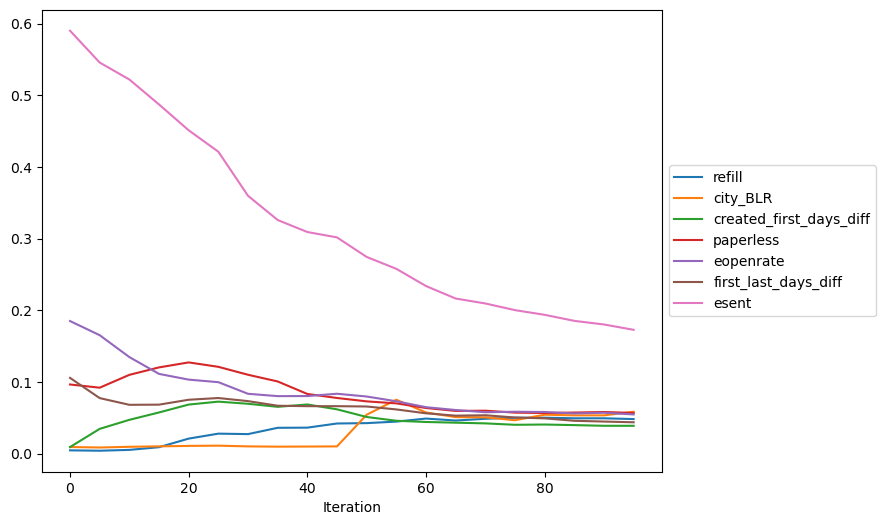

In [41]:
plot_feature_importance(trial, importance_type="cover")

### SHAP

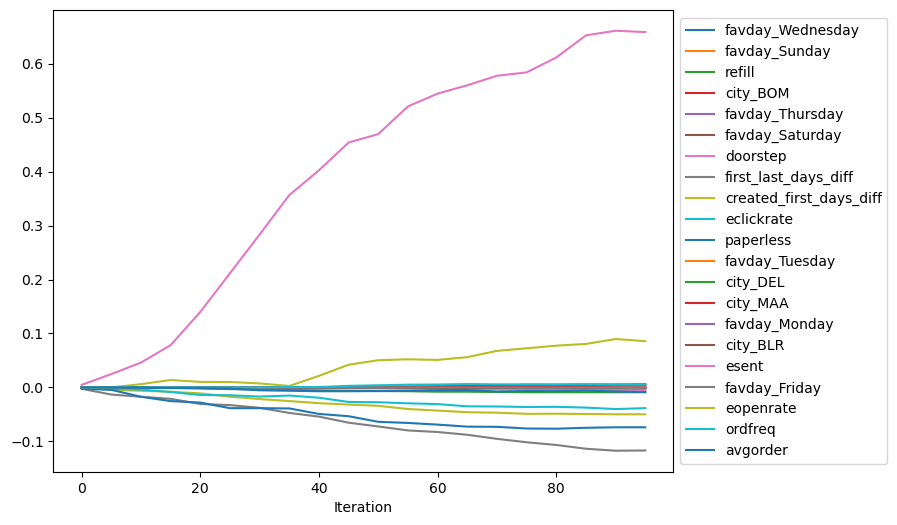

In [42]:
plot_collection(trial, "average_shap")


### Global Explanations

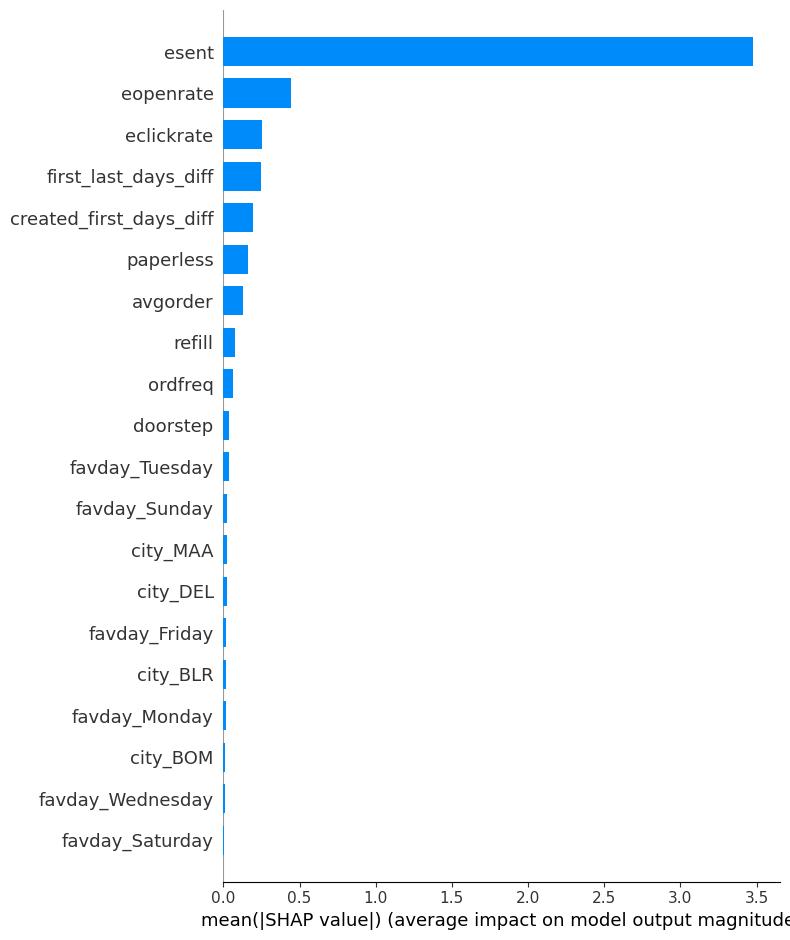

In [43]:
shap_values = trial.tensor("full_shap/f0").value(trial.last_complete_step)
shap_no_base = shap_values[:, :-1]
shap_base_value = shap_values[0, -1]
shap.summary_plot(shap_no_base, plot_type="bar", feature_names=feature_names)

In [44]:
shap_base_value

2.0470693

In [45]:
train_shap = pd.DataFrame(train[:,1:],columns=feature_names)

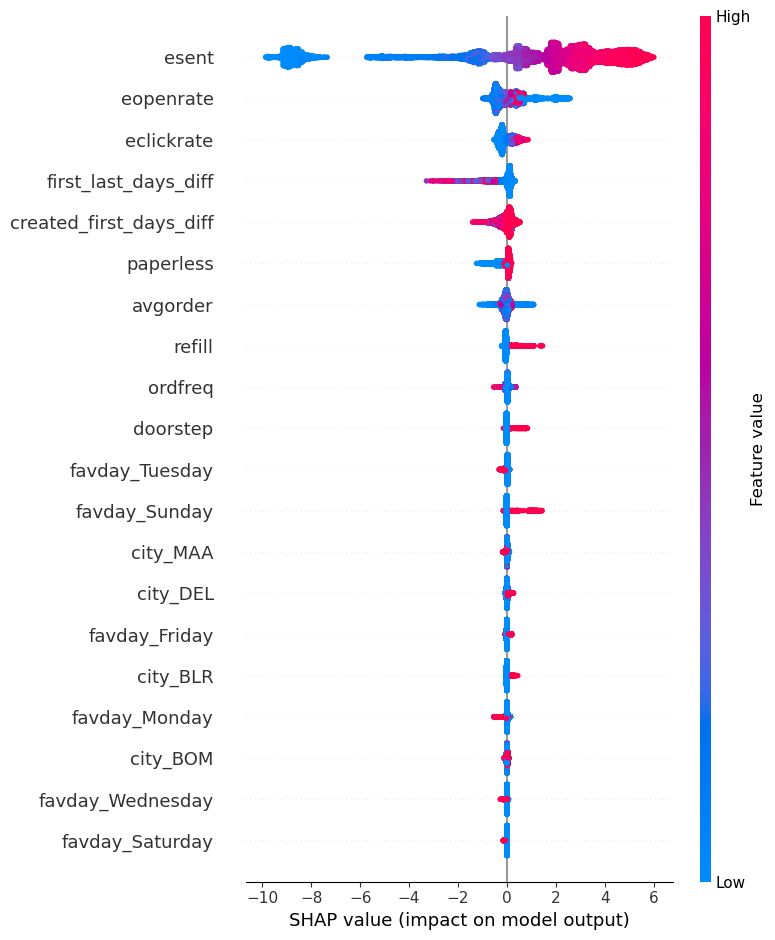

In [46]:
shap.summary_plot(shap_no_base, train_shap)

### Local Explanations

In [47]:
shap.initjs()

In [48]:
shap.force_plot(
    shap_base_value,
    shap_no_base[100, :],
    train_shap.iloc[100, :],
    link="logit",
    matplotlib=False,
)

In [49]:
N_ROWS = shap_no_base.shape[0]
N_SAMPLES = min(100, N_ROWS)
sampled_indices = np.random.randint(N_ROWS, size=N_SAMPLES)

In [50]:
shap.force_plot(
    shap_base_value,
    shap_no_base[sampled_indices, :],
    train_shap.iloc[sampled_indices, :],
    link="logit",
)